# Sync soundtrack with video using audio fingerprinting

Audio fingerprinting approach

In [1]:
%matplotlib inline

import re
import sys
from StringIO import StringIO

import numpy as np, scipy, matplotlib, matplotlib.pyplot as plt, IPython.display as ipd
import audfprint.audfprint as audfprint
import librosa, librosa.display

## Perform audio fingerprinting

Using the **audfprint** library https://github.com/dpwe/audfprint

Create the database w/ soundtrack:

In [26]:
# db_path = "data/whysoserious.pklz"
# s_path = "data/01 Why So Serious?.wav"
# v_path = "data/The Dark Knight - Opening Sequence (2008).wav"

db_path = "data/ratatouille.pklz"
s_path = "data/10 - Is It Soup Yet?.wav"
v_path = "data/Ratatouille - Soup Scene (2007).wav"

s_density = 100.0 # Default = 20.0
v_density = s_density * 2

cmd = ["_", "new",
       "--dbase", db_path,
       "--density", s_density,
       s_path]
audfprint.main(cmd)

Sat Feb 17 17:55:26 2018 ingesting #0: data/10 - Is It Soup Yet?.wav ...
Added 8125 hashes (105.9 hashes/sec)
Processed 1 files (76.7 s total dur) in 0.6 s sec = 0.007 x RT
Saved fprints for 1 files ( 8125 hashes) to data/ratatouille.pklz (0.00% dropped)


Match it w video track:

In [27]:
cmd = ["_", "match",
       "--dbase", db_path,
       "--density", v_density,
       "--find-time-range",
       v_path]
audfprint.main(cmd)

Sat Feb 17 17:55:38 2018 Reading hash table data/ratatouille.pklz
Read fprints for 1 files ( 8125 hashes) from data/ratatouille.pklz (0.00% dropped)
Sat Feb 17 17:55:48 2018 Analyzed #0 data/Ratatouille - Soup Scene (2007).wav of 232.850 s to 102654 hashes
Matched   40.3 s starting at    4.8 s in data/Ratatouille - Soup Scene (2007).wav to time    3.8 s in data/10 - Is It Soup Yet?.wav with    65 of  3910 common hashes at rank  0
Processed 1 files (232.9 s total dur) in 13.0 s sec = 0.056 x RT


Save print output to StringIO instance:

In [28]:
original_stdout = sys.stdout
fprint_result = StringIO()
sys.stdout = fprint_result

Run the match command again:

In [29]:
audfprint.main(cmd)
fprint_result.getvalue()

'Sat Feb 17 17:56:09 2018 Reading hash table data/ratatouille.pklz\nRead fprints for 1 files ( 8125 hashes) from data/ratatouille.pklz (0.00% dropped)\nSat Feb 17 17:56:18 2018 Analyzed #0 data/Ratatouille - Soup Scene (2007).wav of 232.850 s to 102654 hashes\nMatched   40.3 s starting at    4.8 s in data/Ratatouille - Soup Scene (2007).wav to time    3.8 s in data/10 - Is It Soup Yet?.wav with    65 of  3910 common hashes at rank  0\nProcessed 1 files (232.9 s total dur) in 12.9 s sec = 0.056 x RT\n'

Let's set the stdout back and format `fprint_result`:

In [30]:
sys.stdout = original_stdout
fprint_result = fprint_result.getvalue()

And then parse the result for the info we want:

In [31]:
# re.search(r"Matched.*Processed", fprint_result).group()
fprint_data_str = re.search("Matched.*", fprint_result).group()
# fprint_data_list = re.findall("\d+[\.]*\d+", fprint_data_str)

fprint_length = float(re.search("(?<=Matched)\s+\d+[\.]*\d+", fprint_data_str).group().strip())
fprint_vt = float(re.search("(?<=starting at)\s+\d+[\.]*\d+", fprint_data_str).group().strip())
fprint_st = float(re.search("(?<=to time)\s+\d+[\.]*\d+", fprint_data_str).group().strip())
fprint_rank0_common_hashes = float(re.search("(?<=with)\s+\d+\s+(?=of)", fprint_data_str).group().strip())
fprint_total_common_hashes = float(re.search("\d+\s+(?=common hashes)", fprint_data_str).group().strip())
# fprint_rank = float(re.search("(?<=at rank)\s+\d+", fprint_data_str).group().strip())

(fprint_length, fprint_vt, fprint_st, fprint_rank0_common_hashes, fprint_total_common_hashes)

(40.3, 4.8, 3.8, 65.0, 3910.0)

In [32]:
print("Ratio of rank 0 common hashes to total common hashes: {}".format(fprint_rank0_common_hashes / fprint_total_common_hashes))

Ratio of rank 0 common hashes to total common hashes: 0.0166240409207


## Load audio files

In [33]:
s, sr = librosa.load(s_path)
v,_ = librosa.load(v_path)

## Align tracks

Encapsulating some of the alignment code from the previous DTW-approach notebook:

In [34]:
def align_tracks(audio_tup, time_tup, sr):
    s, v = audio_tup
    st, vt = time_tup
    st_vt_diff = abs(st - vt)
    print("st_vt_diff={}".format(st_vt_diff))
    
    # Pad at beginning (to align)
    offset_samps = librosa.time_to_samples(st_vt_diff, sr=sr)
    s_aligned, v_aligned = s, v

    if st < vt:
        s_aligned = np.concatenate((np.zeros(offset_samps), s), axis=0)
    else:
        v_aligned = np.concatenate((np.zeros(offset_samps), v), axis=0)

    # Pad at end (to normalize duration) 
    sv_length_diff = abs(len(s_aligned) - len(v_aligned))
    if len(s_aligned) < len(v_aligned):
        s_aligned = np.concatenate((s_aligned, np.zeros(sv_length_diff)), axis=0)
    elif len(v_aligned) < len(s_aligned):
        v_aligned = np.concatenate((v_aligned, np.zeros(sv_length_diff)), axis=0)
        
    print("New length: {}".format(len(s_aligned)))
    
    return (s_aligned, v_aligned)

In [35]:
sa, va = align_tracks((s, v), (fprint_st, fprint_vt), sr)

st_vt_diff=1.0
New length: 5136384


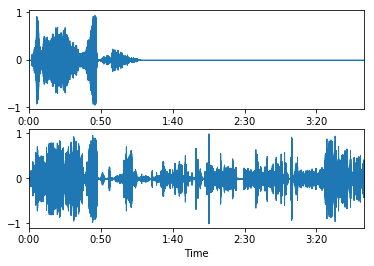

In [36]:
plt.subplot(2, 1, 1)
librosa.display.waveplot(sa, sr=sr)
plt.subplot(2, 1, 2)
librosa.display.waveplot(va, sr=sr)

In [53]:
ipd.Audio((sa + va)[:sr * 60], rate=sr)

Compare this to the original audio from just the video file:

In [54]:
ipd.Audio(v[:sr * 60], rate=sr)

## Save new video with aligned soundtrack audio

In [49]:
vv_path = "data/Ratatouille - Soup Scene (2007).mp4"
sa_path = "data/ratatouille_soup_aligned.wav"
vs_path = "data/rataouille_soup_aligned_soundtrack.mp4" # Video with soundtrack audio
librosa.output.write_wav(sa_path, sa, sr=sr)

In [52]:
%%bash -s "$vv_path" "$sa_path" "$vs_path"
ffmpeg -i "$1" -i "$2" \
-c:v copy -c:a aac -strict experimental \
-map 0:v:0 -map 1:a:0 \
"$3"

ffmpeg version 3.4.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.0.0 (clang-900.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.4.2 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --disable-jack --enable-gpl --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma
  libavutil      55. 78.100 / 55. 78.100
  libavcodec     57.107.100 / 57.107.100
  libavformat    57. 83.100 / 57. 83.100
  libavdevice    57. 10.100 / 57. 10.100
  libavfilter     6.107.100 /  6.107.100
  libavresample   3.  7.  0 /  3.  7.  0
  libswscale      4.  8.100 /  4.  8.100
  libswresample   2.  9.100 /  2.  9.100
  libpostproc    54.  7.100 / 54.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'data/Ratatouille - Soup Scene (2007).mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isomm